In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

# Upload kaggle.json file
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giridharlingampally","key":"5025c2c491caaf37f6e8c3697278b3d2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d dimitreoliveira/cassava-leaf-disease-tfrecords-512x512

Dataset URL: https://www.kaggle.com/datasets/dimitreoliveira/cassava-leaf-disease-tfrecords-512x512
License(s): unknown


In [ ]:
!unzip -q /content/cassava-leaf-disease-tfrecords-512x512.zip -d /content/path_data

In [ ]:
!pip install tensorflow_addons
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install tfa-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.3/620.3 kB 14.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import math

import pandas as pd
import cv2
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.18.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)



print("--------------------------------------------------------------------------------------------------------------------")

Number of replicas: 1
--------------------------------------------------------------------------------------------------------------------


In [ ]:
IMAGE_SIZE = [512, 512]
INPUT_SIZE = [256, 256] #just for fast training
AUTO = tf.data.experimental.AUTOTUNE

def data_pipeline(filenames, label_num, batch_size, is_train=True):
    label_num = tf.constant(label_num, tf.int32)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = dataset.filter(lambda x, y: y == label_num)# only seletcted label number can go through
    dataset = dataset.map(lambda x, y: x, num_parallel_calls=AUTO)# do not use label

    if is_train:
        dataset = dataset.map(data_augmentation, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(64)
        dataset = dataset.repeat()
    dataset = dataset.map(resize_and_normalize, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
        }
    example = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_img(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return img, label

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    return img

def data_augmentation(img):
    # horizontal flip
    if tf.random.uniform(()) > 0.5:
        img = img[:, ::-1, :]

    # vertical flip
    if tf.random.uniform(()) > 0.5:
        img = img[::-1, :, :]

    # random crop
    if tf.random.uniform(()) > 0.3:
        height = tf.random.uniform(shape=(), minval=450, maxval=500)
        width = tf.random.uniform(shape=(), minval=450, maxval=500)
        img = tf.image.random_crop(img, [height,width,3])

    # change brightness and contrast
    contrast_rate = tf.random.uniform(shape=(), minval=0.8, maxval=1.2)
    img = tf.image.adjust_contrast(img, contrast_rate)

    brightness_shift = tf.random.uniform(shape=(), minval=-20, maxval=20)
    img = tf.image.adjust_brightness(img, brightness_shift)
    img = tf.clip_by_value(img, 0, 255)

    # change hue
    hue_rate = tf.random.uniform(shape=(), minval=-0.05, maxval=0.05)
    img = tf.image.adjust_hue(img, hue_rate)

    return img

def resize_and_normalize(img):
    img = img[tf.newaxis, ...]
    img = tf.image.resize(img, tuple(INPUT_SIZE))[0,:,:,:]
    img = (img/127.5) - 1
    return img
print("--------------------------------------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------------------------------------


In [ ]:
def build_gan_models():
    generator_x2y = build_generator()
    generator_y2x = build_generator()
    discriminator_x = build_discriminator()
    discriminator_y = build_discriminator()
    return generator_x2y, generator_y2x, discriminator_x, discriminator_y


def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def build_generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    # I use pretrained model of VGG instead of the model given in the original notebook,
    # because this classification task is much more difficult than the original task(Monet or photo).
    pretrained_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False ,input_shape=[256,256, 3])
    x = pretrained_model(inputs)

    last =  tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inputs, outputs=last)


def discriminator_loss(real, generated):
    bc_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    real_loss = bc_loss(tf.ones_like(real), real)# real as real
    generated_loss = bc_loss(tf.zeros_like(generated), generated)# fake as fake
    #loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    bc_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)# fake as real
    return bc_loss(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 5 * loss


class CycleGan(tf.keras.Model):
    def __init__(
        self,
        generator_x2y,
        generator_y2x,
        discriminator_x,
        discriminator_y,
    ):
        super(CycleGan, self).__init__()
        self.generator_x2y = generator_x2y
        self.generator_y2x = generator_y2x
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y

    def compile(
        self,
        generator_x2y_optimizer,
        generator_y2x_optimizer,
        discriminator_x_optimizer,
        discriminator_y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.generator_x2y_optimizer = generator_x2y_optimizer
        self.generator_y2x_optimizer = generator_y2x_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer
        self.generator_loss = gen_loss_fn
        self.discriminator_loss = disc_loss_fn
        self.cycle_loss = cycle_loss_fn
        self.identity_loss = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data
        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y
            # Generator F translates Y -> X.

            fake_y = self.generator_x2y(real_x, training=True)
            cycled_x = self.generator_y2x(fake_y, training=True)

            fake_x = self.generator_y2x(real_y, training=True)
            cycled_y = self.generator_x2y(fake_x, training=True)

            # same_x and same_y are used for identity loss. in half cycle, do not change original image
            same_x = self.generator_y2x(real_x, training=True)
            same_y = self.generator_x2y(real_y, training=True)

            # discriminate 4 images in total
            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)

            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # calculate the loss
            gen_x2y_loss = self.generator_loss(disc_fake_y)
            gen_y2x_loss = self.generator_loss(disc_fake_x)

            total_cycle_loss = self.cycle_loss(real_x, cycled_x) + self.cycle_loss(real_y, cycled_y)

            # Total generator loss = adversarial loss + cycle loss
            total_gen_x2y_loss = gen_x2y_loss + total_cycle_loss + self.identity_loss(real_y, same_y)
            total_gen_y2x_loss = gen_y2x_loss + total_cycle_loss + self.identity_loss(real_x, same_x)

            disc_x_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self.discriminator_loss(disc_real_y, disc_fake_y)

        # Calculate the gradients for generator and discriminator
        generator_x2y_gradients = tape.gradient(total_gen_x2y_loss,
                                              self.generator_x2y.trainable_variables)
        generator_y2x_gradients = tape.gradient(total_gen_y2x_loss,
                                              self.generator_y2x.trainable_variables)

        discriminator_x_gradients = tape.gradient(disc_x_loss,
                                                  self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss,
                                                  self.discriminator_y.trainable_variables)

        # Apply the gradients to the optimizer
        generator_x2y_optimizer.apply_gradients(zip(generator_x2y_gradients,
                                                  self.generator_x2y.trainable_variables))

        generator_y2x_optimizer.apply_gradients(zip(generator_y2x_gradients,
                                                  self.generator_y2x.trainable_variables))

        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                      self.discriminator_x.trainable_variables))

        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                      discriminator_y.trainable_variables))


        return {
                "gen_x2y_loss": total_gen_x2y_loss,
                "gen_y2x_loss": total_gen_y2x_loss,
                "disc_x_loss": disc_x_loss,
                "disc_y_loss": disc_y_loss
                }
    def call(self, inputs, training=None):
        real_x, real_y = inputs
        # Perform the forward pass for inference
        fake_y = self.generator_x2y(real_x, training=training)
        cycled_x = self.generator_y2x(fake_y, training=training)
        fake_x = self.generator_y2x(real_y, training=training)
        cycled_y = self.generator_x2y(fake_x, training=training)

        # Depending on what you want to return during inference,
        # you can adjust the output. Here, I'm returning the generated images:
        return fake_y, cycled_x, fake_x, cycled_y
print("-----------------------------------------------------*____________________________________________________________")

-----------------------------------------------------*____________________________________________________________


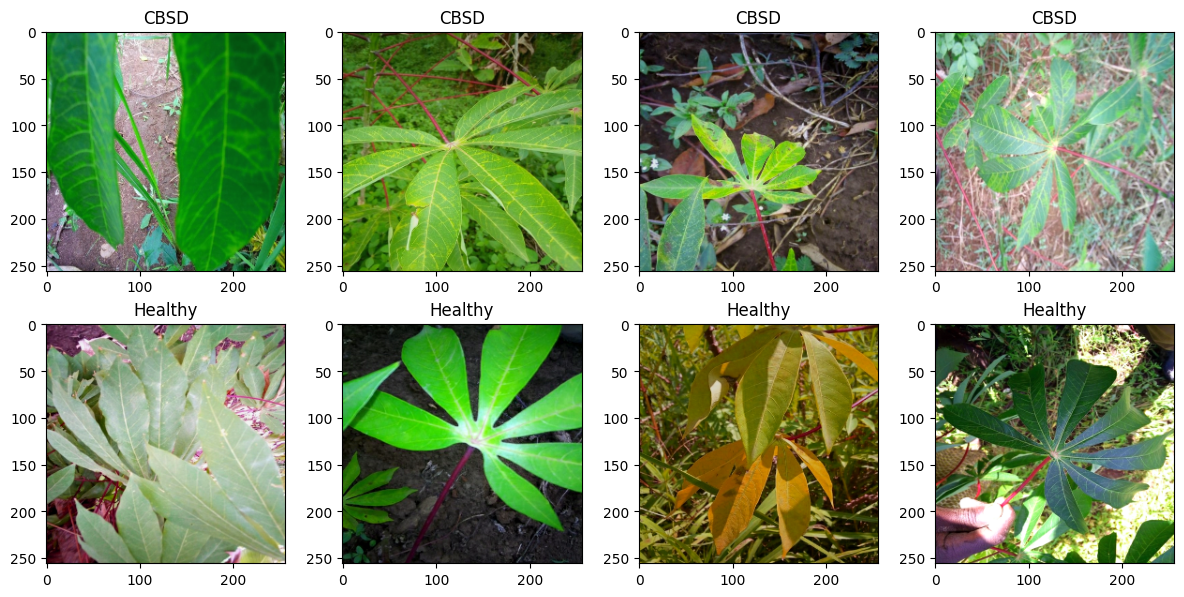

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import glob


# Define the path to your TFRecord files on your local machine
# Update this path based on the location of your TFRecord files
# /content/dataset_folder/Id_train00-1427.tfrec
# /content/path_data/Id_train00-1427.tfrec
local_tfrec_path = '/content/path_data'

# Update the batch size
batch_size = 5
filenames = glob.glob(local_tfrec_path + '/Id_train*.tfrec')

CBSD_data = data_pipeline(filenames, label_num=1, batch_size=batch_size, is_train=True)
Healthy_data = data_pipeline(filenames, label_num=4, batch_size=batch_size, is_train=True)

num_samples = 4

fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))

# Display CBSD samples
for i,data in enumerate(CBSD_data.take(num_samples)):
    axes[0, i].imshow(data[0].numpy() * 0.5 + 0.5)
    axes[0, i].title.set_text("CBSD")

# Display Healthy samples
for i, data in enumerate(Healthy_data.take(num_samples)):
    axes[1, i].imshow(data[0].numpy() * 0.5 + 0.5)
    axes[1, i].title.set_text("Healthy")

fig.tight_layout()
plt.show()

In [ ]:
print("_____________________----after images______________________")
data_num = 2000
learning_rate = 1e-4
batch_size = 5

with strategy.scope():
    generator_x2y, generator_y2x, discriminator_x, discriminator_y = build_gan_models()


    # loss and learning rate
    generator_x2y_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    generator_y2x_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate/10, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate/10, beta_1=0.5)

    cycle_gan_model = CycleGan(generator_x2y, generator_y2x, discriminator_x, discriminator_y)



    def compile_and_fit(epochs):
        cycle_gan_model.compile(generator_x2y_optimizer, generator_y2x_optimizer,
                                discriminator_x_optimizer, discriminator_y_optimizer, # Pass optimizers here
                                generator_loss,
                                discriminator_loss,
                                calc_cycle_loss,
                                identity_loss
                                )
        cycle_gan_model.fit(tf.data.Dataset.zip((CBSD_data, Healthy_data)),
                            batch_size = batch_size,
                            steps_per_epoch = data_num//batch_size,
                            epochs=epochs
                           )


    # I don't want to break the pretrained weight of disciminator at initial epochs.
    compile_and_fit(epochs=10)
    # compile_and_fit(epochs=10)
    for batch_data in tf.data.Dataset.zip((CBSD_data, Healthy_data)).take(1):
        cycle_gan_model(batch_data)

    cycle_gan_model.save_weights("gan_10ep_CBSD_healthy.weights.h5")

_____________________----after images______________________
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 510s 954ms/step - disc_x_loss: 0.1270 - disc_y_loss: 0.0862 - gen_x2y_loss: 12.0410 - gen_y2x_loss: 10.8395
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 385s 962ms/step - disc_x_loss: 0.3014 - disc_y_loss: 0.1893 - gen_x2y_loss: 7.0022 - gen_y2x_loss: 6.2548
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 385s 962ms/step - disc_x_loss: 0.3751 - disc_y_loss: 0.3162 - gen_x2y_loss: 5.5337 - gen_y2x_loss: 5.2147
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 384s 961ms/step - disc_x_loss: 0.4605 - disc_y_loss: 0.4099 - gen_x2y_loss: 4.4521 - gen_y2x_loss: 4.2388
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 384s 960ms/step - disc_x_loss: 0.4962 - disc_y_loss: 0.4295 - gen_x2y_loss: 4.0452 - gen_y2x_loss: 3.7693
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 384s 960ms/step - disc_x_loss: 0.5038 - disc_y_loss: 0.4359 - gen_x2y_loss: 3.8415 - gen_y2x_loss: 3.5446
Epoch 7/10


In [ ]:
print("CBSD----------------->HEALTHY")



def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0]]
    title = ['Original Image', 'Generated Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

for inputs in CBSD_data.take(12):
    generate_images(generator_x2y, inputs)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("HEALTHY---------------->CBSD")
for inputs in Healthy_data.take(12):
    generate_images(generator_y2x, inputs)

Output hidden; open in https://colab.research.google.com to view.